c:\Users\milan\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


+---------------------------------------------------------------------------------------------------------+
|                                         Columnname: Review Title                                        |
+---------+---------+------+-----------------------------------------------------------------+------------+
| entries | Uniques | NaNs |                          Most Frequent                          |   Types    |
+---------+---------+------+-----------------------------------------------------------------+------------+
|   375   |   356   |  0   | TERRIBLE ATTITUDE!!!!DONT GO!!!!                              3 | str    375 |
|         |         |      | A boring four and a half hours that could have been superb    3 |            |
|         |         |      | Amazing Experience                                            2 |            |
|         |         |      | Rude and inflexible                                           2 |            |
|         |         |      |

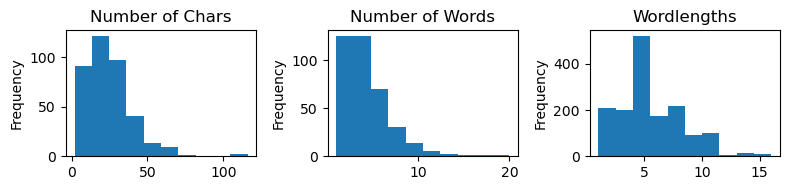

+--------------------------------------------------+
|       N-Grams (702 words, 23 unique words)       |
+---------------+----------------------------------+
|     1-Gram    | 11 entries contain abbreviations |
+---------------+----------------------------------+
| and        53 |          TERRIBLE    3           |
| Great      44 |          ATTITUDE    3           |
| food       31 |          DONT        3           |
| in         30 |          GO          3           |
| a          29 |          TA          3           |
| the        23 |          SHAMEFUL    2           |
| service    22 |          DEFINITE    1           |
| place      20 |          PLACE       1           |
| to         16 |          TO          1           |
| of         15 |          VISIT       1           |
+---------------+----------------------------------+


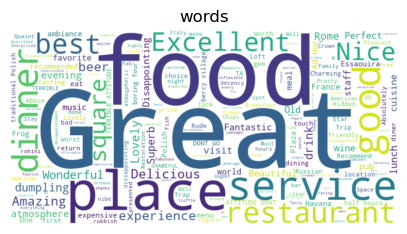

+------------------------------------------------------------+
|                        Whitespaces                         |
+------------+---------------------------------+-------------+
| leading ws | strings with excessive inner ws | trailing ws |
+------------+---------------------------------+-------------+
|  0    375  |                3                |   0    375  |
+------------+---------------------------------+-------------+
+-------------------------------------------------------------------------------------------------------------------------------------------+
|                                                       Letters (375 entries in total)                                                      |
+----------------------------------------------------+---------------+----------------------------------+-----------------------------------+
|                contains letter 372                 | no letter (3) |      all letters upper (6)       |       all letters lower (14

[101    False
 125    False
 41     False
 215    False
 279    False
        ...  
 373    False
 311    False
 169    False
 372    False
 318    False
 Name: Review Title, Length: 375, dtype: bool]

In [1]:
# demo data: https://www.kaggle.com/datasets/gorororororo23/european-restaurant-reviews

from typing import List
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle


class ColAnalyzer:     
    def __init__(
            self, 
            col: pd.Series, 
            n_grams: List[int] = [1, 2, 3], 
            n_clusters: int = 3, 
            n_examples: int = 5, 
            quantiles: List[float] = [0, .1, .25, .5, .75, .9, 1],
            calculate_embeddings: bool = True,
            minilm_pkl_file: str = None):
        self.col = col
        self.string_col = col[col.apply(lambda x: isinstance(x, str))]
        self.text = " ".join(self.string_col)
        self.n_grams = n_grams
        self.n_clusters = n_clusters
        self.n_examples = n_examples
        self.quantiles = quantiles
        if minilm_pkl_file is None:
            self.minilm = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        else:
            with open(minilm_pkl_file, "rb") as f:
                self.minilm = pickle.load(f)
        if calculate_embeddings:
            self.embeddings = self._minilm_embeddings(self.string_col)
        else:
            self.embeddings = None
        
    @staticmethod
    def isfloat(string: str) -> bool:
        try:
            float(string)
            return True
        except:
            return False
    
    def _minilm_embeddings(self, string_col: pd.Series):
        return self.minilm.encode(string_col.values)
        
    def _anomalies_isolation_forest(self) -> str:
        iso_forest = IsolationForest(n_estimators=100, contamination=0.01).fit(self.embeddings)
        results = pd.DataFrame({'document': self.string_col.values, 'score': iso_forest.decision_function(self.embeddings)})
        return results.sort_values(by='score', ascending=True).head(self.n_examples)["document"].to_string(dtype=False, index=False)
    
    def _anomalies_one_class_svm(self) -> str:
        ocs = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1).fit(self.embeddings)
        results = pd.DataFrame({'document': self.string_col.values, 'score': ocs.decision_function(self.embeddings)})
        return results.sort_values(by='score', ascending=True).head(self.n_examples)["document"].to_string(dtype=False, index=False)
    
    def _clusters_agg(self) -> str:
        agg_clustering = AgglomerativeClustering(n_clusters=self.n_clusters).fit(self.embeddings)
        clusters = agg_clustering.labels_
        
        results = []
        # For each cluster, find the 3 closest strings to the cluster center
        for cluster in range(self.n_clusters):
            cluster_indices = np.where(clusters == cluster)[0]
            cluster_embeddings = self.embeddings[cluster_indices]
            cluster_center = cluster_embeddings.mean(axis=0)
            
            distances = euclidean_distances(cluster_embeddings, [cluster_center]).flatten()
            closest_indices = np.argsort(distances)[:self.n_examples]
            
            closest_strings = self.string_col.iloc[cluster_indices[closest_indices]].values
            results.append(pd.Series(closest_strings).to_string(dtype=False, index=False))
        return results

    def _mask_contains_letter(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: bool(re.search('[a-zA-ZäöüÄÖÜß]', x)))

    def _mask_lower_only(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: x == x.lower())
    
    def _mask_upper_only(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: x == x.upper())
    
    def _mask_contains_digit(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: bool(re.search(r"\d", x)))
    
    def _mask_castable_int(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: x.isdigit())
    
    def _mask_castable_float(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: self.isfloat(x))
        
    def _mask_abbreviation(self, string_col: pd.Series) -> pd.Series:
        return string_col.apply(lambda x: bool(re.search(r"[A-ZÖÜÄ]{2,}", x)))

    def _abbreviation_vc(self, text: str) -> pd.Series:
        pattern = r"[A-ZÖÜÄ]{2,}"
        uppercase_words = re.findall(pattern, text)
        return pd.Series(uppercase_words, dtype=object).value_counts().sort_values(ascending=False)
    
    def _wordlens(self, text: str) -> pd.Series:
        words = pd.Series(text.split(" "))
        return words[words.apply(lambda x: x != "")].apply(lambda x: len(x))

    def _ngrams(self, string_col, n: int) -> pd.Series:
        """
        returns a series with index: ngram, value: frequency
        """
        vectorizer = TfidfVectorizer(
                binary=False, 
                norm=None, 
                use_idf=False, 
                ngram_range=(n, n), 
                lowercase=False, 
                stop_words=None)
        ngram_count = vectorizer.fit_transform(string_col).todense()
        return pd.DataFrame(data=ngram_count, columns=vectorizer.get_feature_names_out()).sum().astype(int).sort_values(ascending=False)
    

    def describe(self, 
                 custom_patterns: List[str] = None,
                 use_length: bool = True,
                 use_ngrams: bool = True,
                 use_wordcloud: bool = True,
                 use_whitespaces: bool = True, 
                 use_letters: bool = True,
                 use_digits: bool = True,
                 use_clusters: bool = True,
                 use_anomalies: bool = True):
        # general
        vc = self.col.value_counts(dropna=False).sort_values(ascending=False)
        n_uniques = len(vc)
        n_nans = self.col.isna().sum()
        vc_types = self.col.apply(lambda x: re.findall(r"'(.*?)'", str(type(x)))[0]).value_counts()
        table = PrettyTable(["entries", "Uniques", "NaNs", "Most Frequent", "Types"])
        table.title = f"Columnname: {self.col.name}"
        table.add_row([len(self.col), n_uniques, n_nans, vc.head(self.n_examples).to_string(dtype=False), vc_types.to_string(dtype=False)])
        print(table)

        custom_pattern_masks = self.custom_patterns_check(custom_patterns)
        if use_length: self.length()
        if use_ngrams: self.ngrams()
        if use_wordcloud: self.word_cloud()
        if use_whitespaces: self.whitespaces()
        if use_letters: self.letters()
        if use_digits: self.digits()
        if use_clusters: self.clusters()
        if use_anomalies: self.anomalies()
        return custom_pattern_masks
    

    def custom_patterns_check(self, patterns: List[str]):
        if patterns is not None:
            table = PrettyTable(patterns)
            custom_pattern_masks = []
            row_patterns = []
            row_examples = []
            for pattern in patterns:
                print(pattern)
                mask = self.string_col.apply(lambda x: bool(re.search(pattern, x)))
                custom_pattern_masks.append(mask)
                row_patterns.append(f"{pattern} ({mask.sum()})")
                row_examples.append(self.string_col[mask].head(self.n_examples).to_string(dtype=False, index=False))
            table.add_row(row_patterns)
            table.add_row(row_examples)
            table.title = "Custom Patterns"
            print(table)
            return custom_pattern_masks
        return None

    def length(self):
        length = self.string_col.apply(lambda x: len(x))
        zerolength = length.apply(lambda x: x == 0)
        n_words = self.string_col.apply(lambda x: len(x.split(" ")))
        wordlens = self._wordlens(self.text)
        table = PrettyTable(["level", "with zerolength"] + ["q" + str(q) for q in self.quantiles])
        row_chars = ["N Characters", zerolength.sum()]
        row_words = ["N Words", zerolength.sum()]
        row_wordlens = ["Wordlengths", ""]
        for q in self.quantiles:
            row_chars.append(int(length.quantile(q)))
            row_words.append(int(n_words.quantile(q)))
            row_wordlens.append(int(wordlens.quantile(q)))
        table.add_row(row_chars)
        table.add_row(row_words)
        table.add_row(row_wordlens)
        table.title = "Lengths"
        print(table)
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 2))
        length.plot(kind="hist", ax=axes[0], title="Number of Chars")
        n_words.plot(kind="hist", ax=axes[1], title="Number of Words")
        wordlens.plot(kind="hist", ax=axes[2], title="Wordlengths")
        plt.tight_layout()
        plt.show()

    def ngrams(self):
        abbreviations_freq = self._abbreviation_vc(text=self.text).head(self.n_examples).to_string(dtype=False)
        with_abbreviations = self._mask_abbreviation(self.string_col).sum()
        table = PrettyTable([f"{n}-Gram" for n in self.n_grams] + [f"{with_abbreviations} entries contain abbreviations"])
        row = []
        for n in self.n_grams:
            if n == 1:
                ngram_count = pd.Series(self.text.split(" ")).value_counts().sort_values(ascending=False)
                n_words = len(ngram_count)
                unique_words = len(ngram_count.unique())
            else:
                ngram_count = self._ngrams(string_col=self.string_col, n=n)
            row.append(ngram_count.head(self.n_examples).to_string(dtype=False))
        table.title = f"N-Grams ({n_words} words, {unique_words} unique words)"
        row.append(abbreviations_freq)
        table.add_row(row)
        print(table)

    def word_cloud(self):
        wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(self.text)
        plt.figure(figsize=(5, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")  # Don't show axes for a cleaner look
        plt.title(f"words")
        plt.show()
    
    def whitespaces(self):
        trail_ws = self.string_col.apply(lambda x: len(x) - len(x.rstrip())).value_counts()
        lead_ws = self.string_col.apply(lambda x: len(x) - len(x.lstrip())).value_counts()
        embedded_ws = self.string_col.apply(lambda x: bool(re.search("\s{2,}", x.strip())))
        table = PrettyTable(["leading ws", "strings with excessive inner ws", "trailing ws"])
        table.add_row([lead_ws.to_string(dtype=False), embedded_ws.sum(), trail_ws.to_string(dtype=False)])
        table.title = "Whitespaces"
        print(table)
    
    def letters(self):
        contains_letter = self._mask_contains_letter(self.string_col)
        loweronly = self._mask_lower_only(self.string_col)
        upperonly = self._mask_upper_only(self.string_col)
        cat = [
            f"contains letter {contains_letter.sum()}", 
            f"no letter ({(~contains_letter).sum()})", 
            f"all letters upper ({(upperonly & contains_letter).sum()})", 
            f"all letters lower ({(loweronly & contains_letter).sum()})"]
        table = PrettyTable(cat)
        table.title = f"Letters ({len(self.string_col)} entries in total)"
        table.add_row([
            self.string_col[contains_letter].head(self.n_examples).to_string(dtype=False, index=False), 
            self.string_col[~contains_letter].head(self.n_examples).to_string(dtype=False, index=False),
            self.string_col[(upperonly & contains_letter)].head(self.n_examples).to_string(dtype=False, index=False), 
            self.string_col[(loweronly & contains_letter)].head(self.n_examples).to_string(dtype=False, index=False)])
        print(table)

    def digits(self):
        contains_digit = self._mask_contains_digit(self.string_col)
        is_int = self._mask_castable_int(self.string_col)
        is_float = self._mask_castable_float(self.string_col)
        cat = [
            f"contains digit ({contains_digit.sum()})",
            f"contains no digit ({(~contains_digit).sum()})",
            f"castable to int ({is_int.sum()})", 
            f"castable to float ({is_float.sum()})"]
        table = PrettyTable(cat)
        table.title = f"Embeddid Digits ({len(self.string_col)} entries in total)"
        table.add_row([
            self.string_col[contains_digit].head(self.n_examples).to_string(dtype=False, index=False),
            self.string_col[~contains_digit].head(self.n_examples).to_string(dtype=False, index=False),
            self.string_col[is_int].head(self.n_examples).to_string(dtype=False, index=False), 
            self.string_col[is_float].head(self.n_examples).to_string(dtype=False, index=False)])
        print(table)

    def clusters(self):
        if self.embeddings is None:
            print("no cluster analysis without embeddings")
            return
        table = PrettyTable([str(i + 1) for i in range(self.n_clusters)])
        table.title = "Clusters"
        table.add_row(self._clusters_agg())
        print(table)
    
    def anomalies(self):
        length = self.string_col.apply(lambda x: len(x))
        if self.embeddings is None:
            table = PrettyTable(["Shortest", "Longest"])
            table.add_row([
                self.string_col[length.sort_values().index].head(self.n_examples).to_string(dtype=False, index=False),
                self.string_col[length.sort_values(ascending=False).index].head(self.n_examples).to_string(dtype=False, index=False)])
        else:
            table = PrettyTable(["Shortest", "Longest", "Anomalies: Isolation Forest", "Anomalies: One Class SVM"])
            table.add_row([
                self.string_col[length.sort_values().index].head(self.n_examples).to_string(dtype=False, index=False),
                self.string_col[length.sort_values(ascending=False).index].head(self.n_examples).to_string(dtype=False, index=False), 
                self._anomalies_isolation_forest(),
                self._anomalies_one_class_svm()])
        table.title = "Anomalies"
        print(table)

    def schema_match(self, existing_col: pd.Series):
        if self.embeddings is None:
            print("embeddings not calculated")
            return
        print("entries in <existing_col>:", len(existing_col))
        existing_string_col = existing_col[existing_col.apply(lambda x: isinstance(x, str))]
        print("string entries in <other_string_col>:", len(existing_string_col))
        embeddings_other = self._minilm_embeddings(existing_string_col)
        
        y = np.array(([1] * len(self.embeddings) + [0] * len(embeddings_other)))
        x = np.vstack([self.embeddings, embeddings_other])
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        cls = RandomForestClassifier().fit(x_train, y_train)
        preds = cls.predict(x_test)
        table = PrettyTable(["Accuracy", "Precision", "Recall"])
        table.title = "Classification Scores (the lower, the more similar the columns; Positive Class: <existing_col>)"
        table.add_row([
            round(accuracy_score(y_true=y_test, y_pred=preds), 2), 
            round(precision_score(y_true=y_test, y_pred=preds), 2), 
            round(recall_score(y_true=y_test, y_pred=preds), 2)])
        print(table)


with open("minilm.pkl", "wb") as f:
    pickle.dump(SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2'), f)


data = pd.read_csv("data_in/European Restaurant Reviews.csv")
col = data["Review Title"].sample(frac=1).head(500)
col.index = range(len(col))
col1, col2 = train_test_split(col)
analyzer = ColAnalyzer(col=col1, n_clusters=2, n_examples=10, n_grams=[1], minilm_pkl_file="minilm.pkl")
analyzer.describe(custom_patterns=[r"\+"])

In [2]:
analyzer.schema_match(existing_col=col2)

entries in <existing_col>: 125
string entries in <other_string_col>: 125
+-------------------------------------------------------------------------------------------------+
| Classification Scores (the lower, the more similar the columns; Positive Class: <existing_col>) |
+--------------------------------+------------------------------------+---------------------------+
|            Accuracy            |             Precision              |           Recall          |
+--------------------------------+------------------------------------+---------------------------+
|              0.64              |                0.65                |            0.97           |
+--------------------------------+------------------------------------+---------------------------+
